In [1]:
from symc import SyncSimulation, SyncConfig, SimConfig
from symc.plotting import corner_plot
from symc.likelihoods import LIKELIHOODS

likelihood = LIKELIHOODS['single_gaussian']

In [2]:
from rich.pretty import pprint
import numpy as np
import matplotlib.pyplot as plt

### Famous egg box function 🥚 by default

In [21]:
sim = SyncSimulation()
pprint(sim)

2 dimensional egg_box simulator.

In [22]:
x = sim.sample(10000)
y = sim(x)

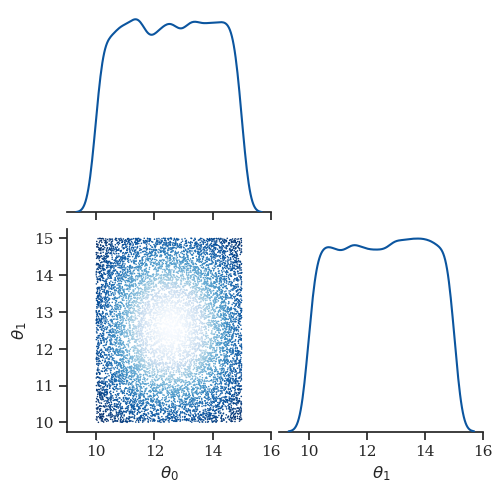

In [23]:
g = corner_plot(x,y)

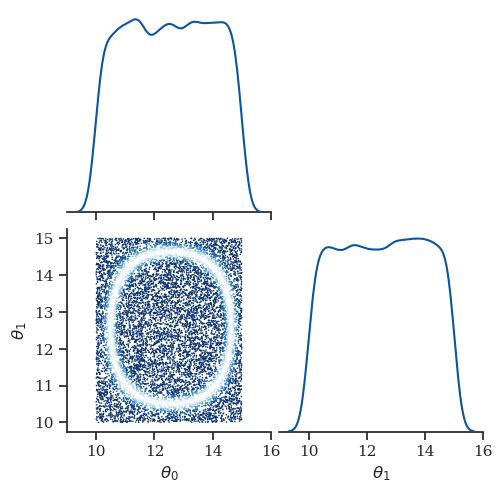

In [25]:
g = corner_plot(x, likelihood(y,goal=100), cmap='Blues_r')
plt.show()

#### More eggs

In [26]:
more_eggs = SyncConfig() 
more_eggs.bounds = ((0, 10*np.pi))
more_eggs

SyncConfig(simulation='egg_box', input_dimension=2, output_dimension=1, bounds=(0, 31.41592653589793), normalised_input=False, norm_limits=(-1, 1), sim_config=None)

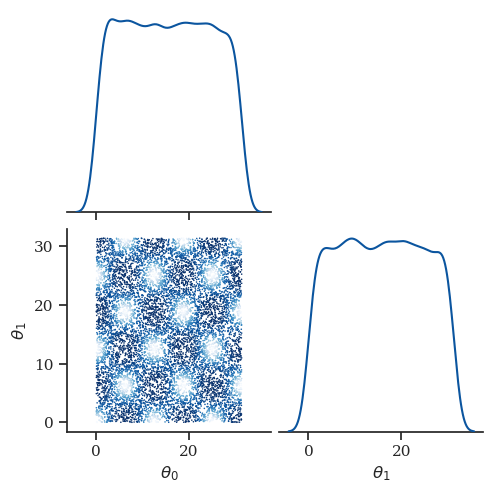

In [27]:
sim = SyncSimulation(sync_config=more_eggs)
x = sim.sample(10000)
y = sim(x)
g = corner_plot(x,y)

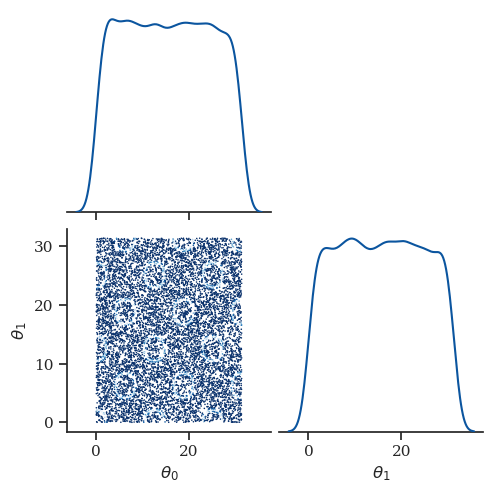

In [28]:
g = corner_plot(x, likelihood(y,goal=100), cmap='Blues_r')
plt.show()

### Rosenbrock function 🍌

In [8]:
rosenbrock = SyncConfig()
rosenbrock.simulation = 'rosenbrock2d'
rosenbrock.bounds = [[-1.5, 1.5],[0.,2.],[0.,1.]]
rosenbrock.input_dimension = 3
pprint(rosenbrock)

SyncConfig(
│   simulation='rosenbrock2d',
│   input_dimension=3,
│   output_dimension=1,
│   bounds=[[-1.5, 1.5], [0.0, 2.0], [0.0, 1.0]],
│   normalised_input=False,
│   norm_limits=(-1, 1),
│   sim_config=None
)

In [9]:
sim = SyncSimulation(sync_config=rosenbrock)

In [10]:
x = sim.sample(10000)
y = sim(x)

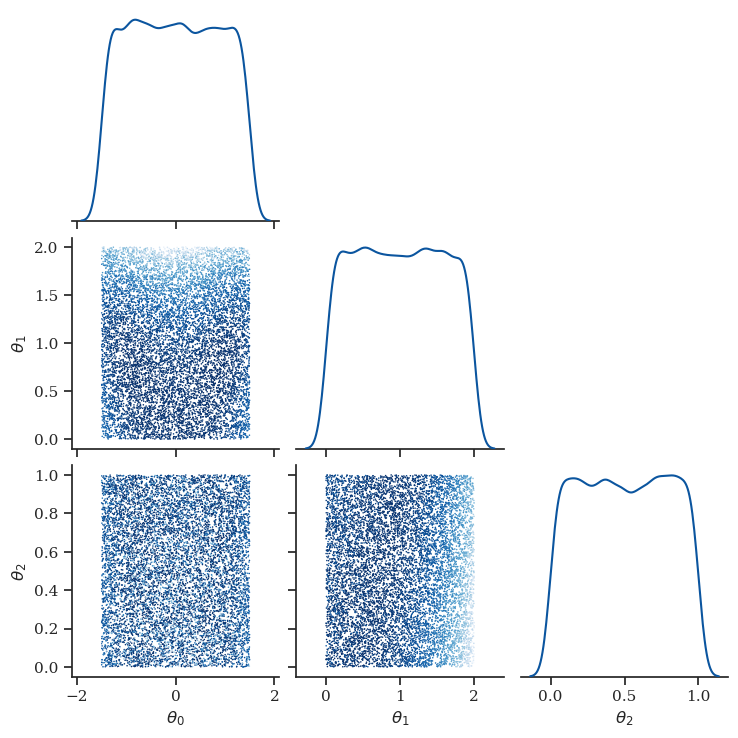

In [11]:
corner_plot(x,y)

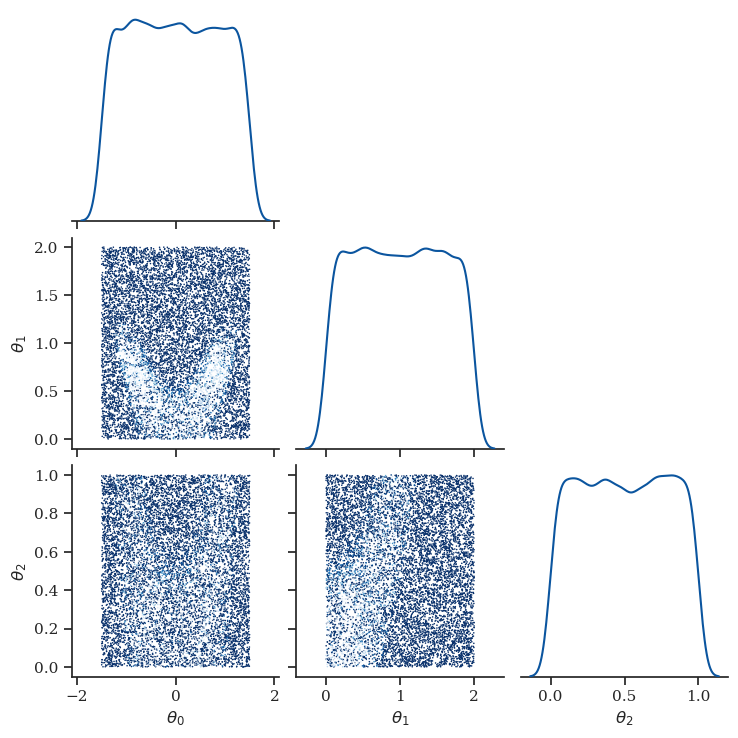

In [20]:
g = corner_plot(x, likelihood(y,goal=10), cmap='Blues_r')
plt.show()

In [3]:
from bayes_opt import BayesianOptimization


In [4]:
# Bounded region of parameter space
pbounds = {'x': (2, 4), 'y': (-3, 3)}

def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

In [5]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [6]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -7.135    | 2.834     | 1.322     |
| 2         | -7.78     | 2.0       | -1.186    |
| 3         | -7.11     | 2.218     | -0.7867   |
| 4         | -12.4     | 3.66      | 0.9608    |
| 5         | -6.999    | 2.23      | -0.7392   |


In [4]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

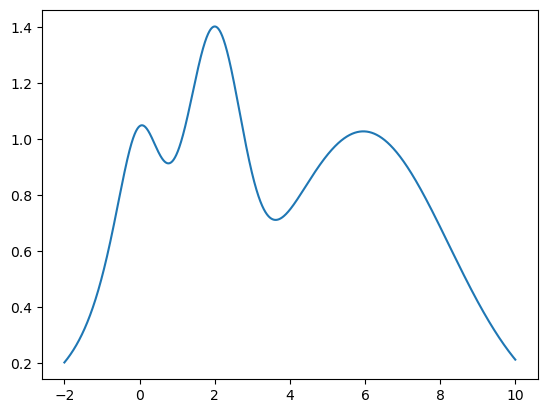

In [5]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y);

In [9]:
optimizer = BayesianOptimization(target, {'x': (-2, 10)}, random_state=27)


In [10]:
optimizer.maximize(init_points=2, n_iter=0)


|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |


In [11]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

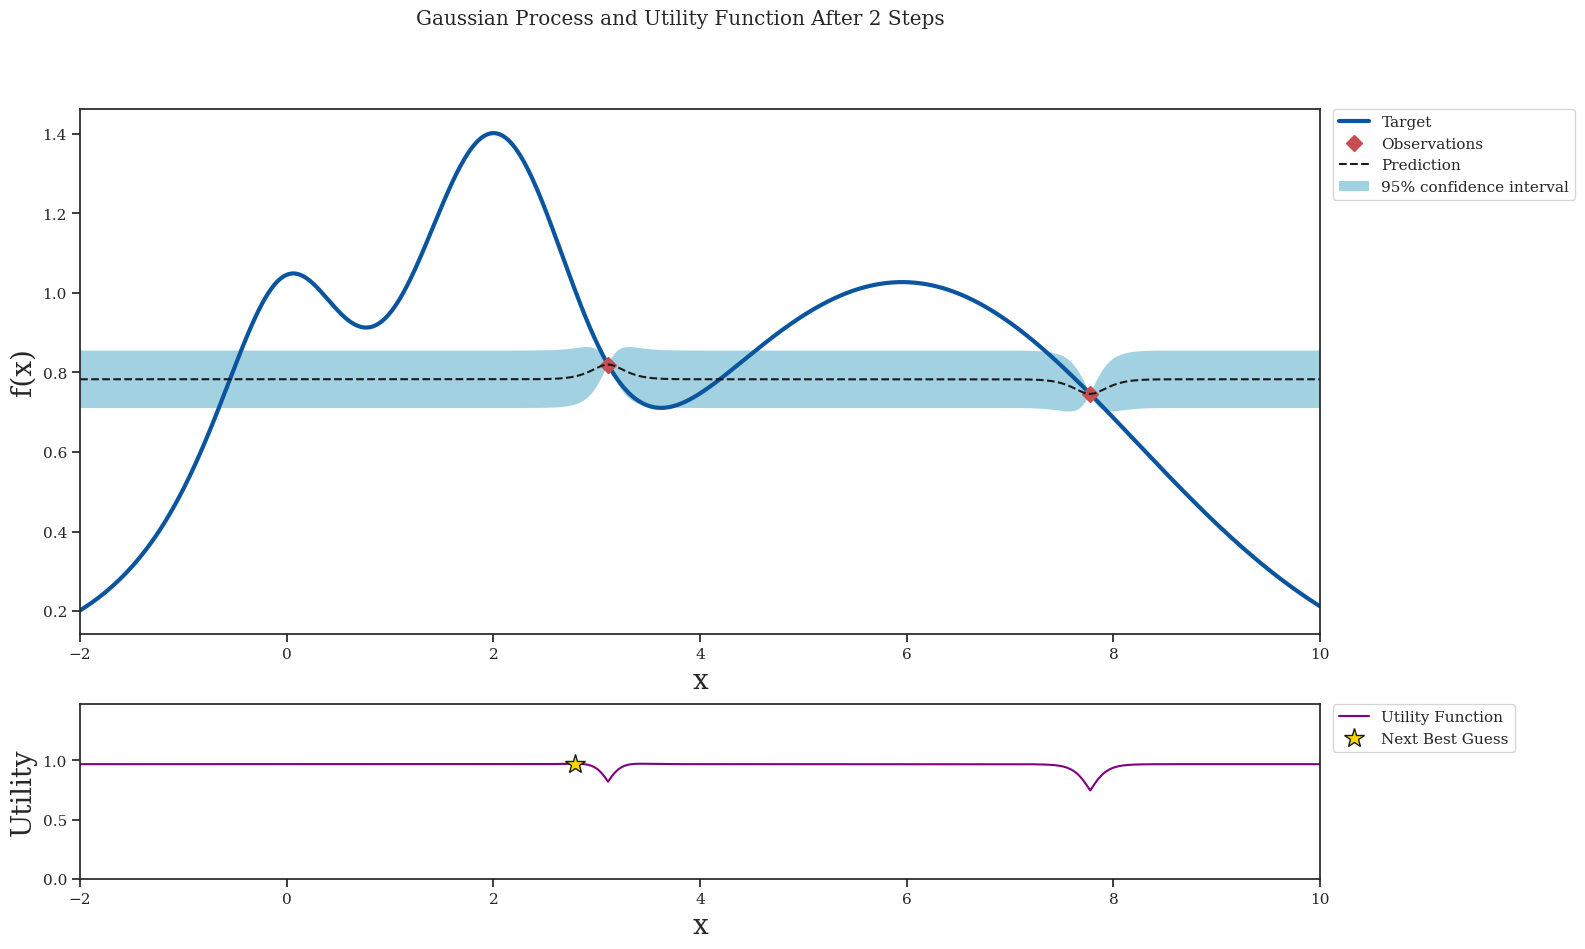

In [12]:
plot_gp(optimizer, x, y)


|   iter    |  target   |     x     |
-------------------------------------
| 3         | 0.5234    | -0.9694   |


/home/mjad1g20/.conda/envs/newhep/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


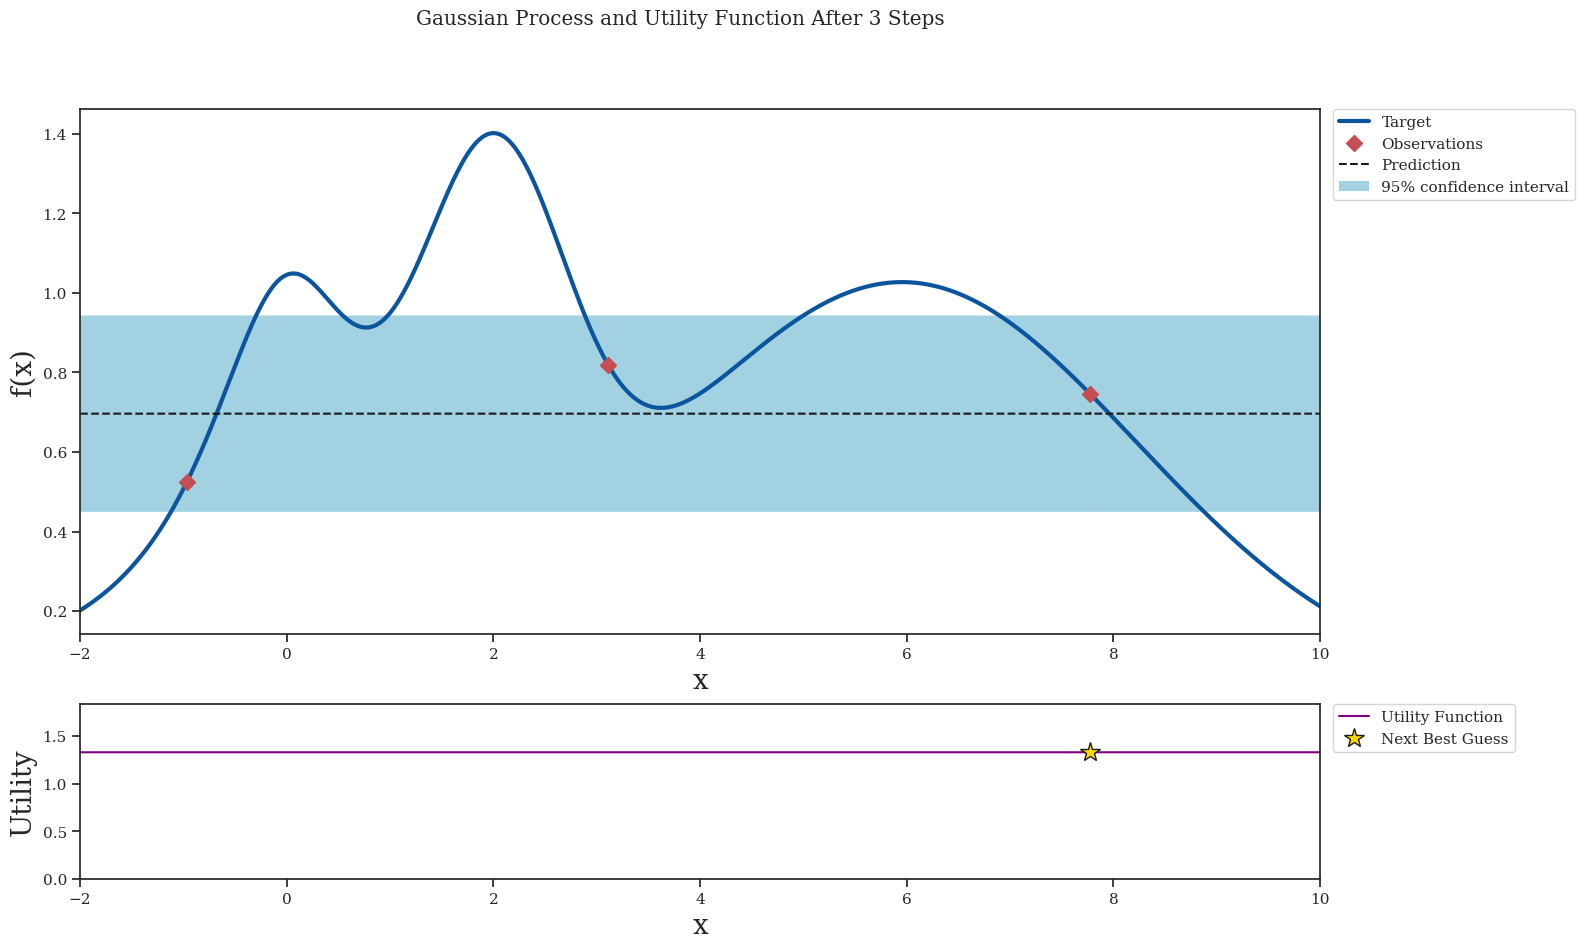

In [13]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 9         | 1.024     | 5.774     |


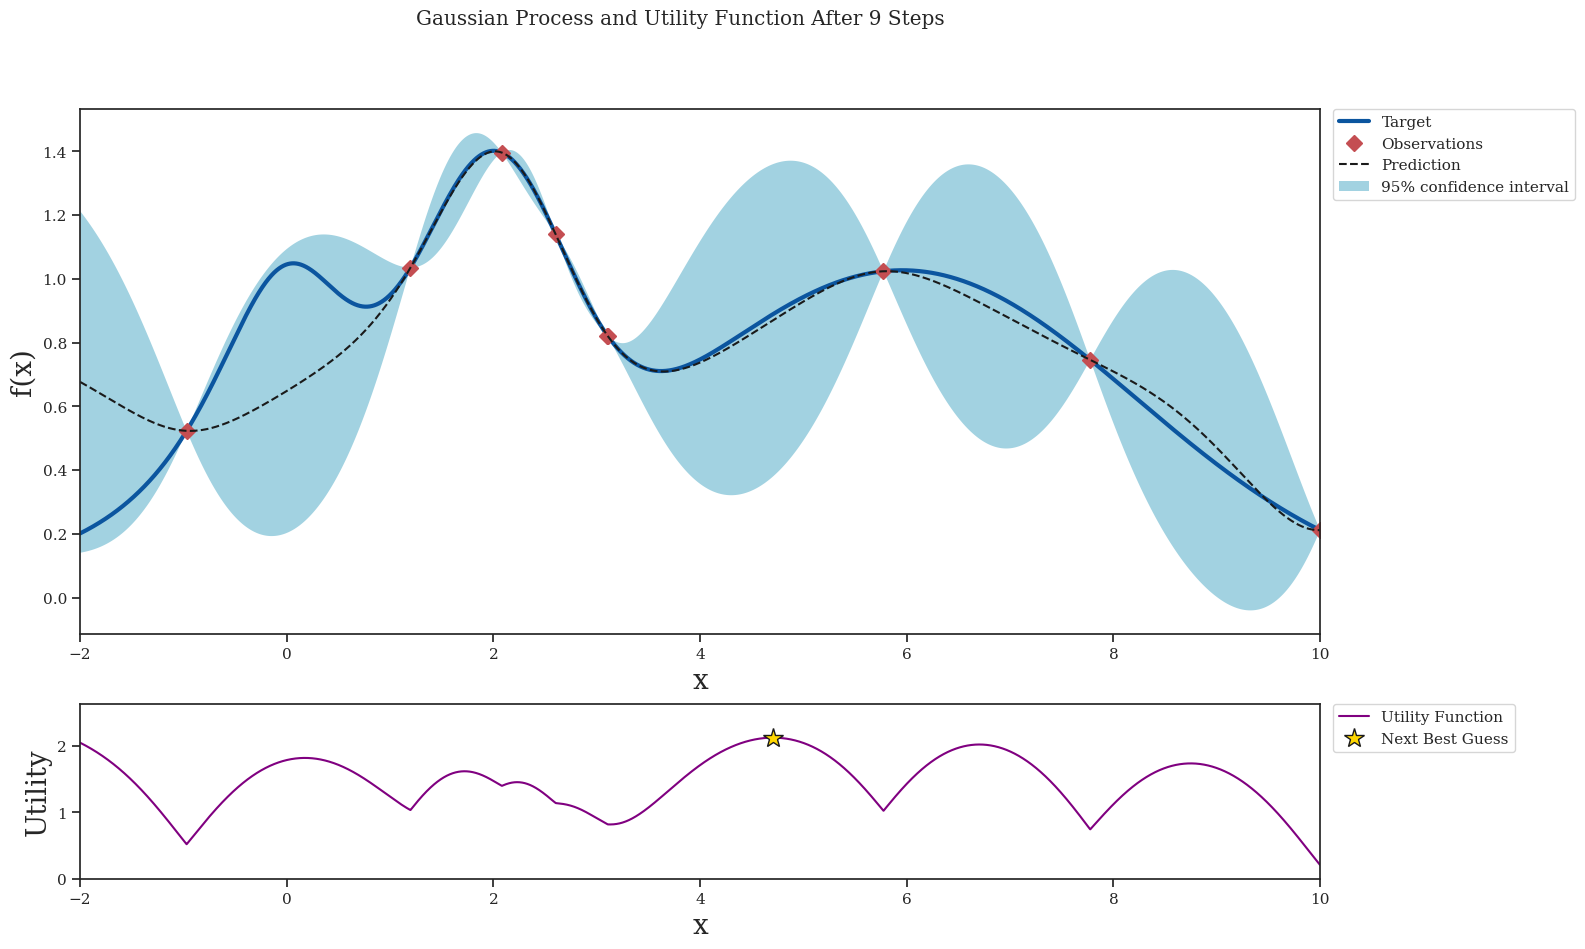

In [19]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

In [2]:
import torch
import gpytorch
from matplotlib import pyplot as plt

In [9]:
x = np.random.uniform(-2, 10, 5)
y = target(x)

In [11]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
train_x = torch.tensor(x).float()
train_y = torch.tensor(y).float()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [15]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  
# Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 4
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

KeyboardInterrupt: 